In [18]:
from pprint import pprint
import re
import pandas as pd
from scipy import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import sympy as sym
from scipy.interpolate import interp1d

dictpat = r'\{((?:\s*\w+\s*:\s*\D+\w+.\d+\s*)+)\}' # note non-capturing (?:) inner group
itempat = r'(\s*(\w+)\s*:\s*(\D+\w+.\d+)\s*)'      # which is captured in this expr

with open('reference_points.pb.txt') as f:
    lod = [{group[1]:group[2] for group in re.findall(itempat, items)}
                                for items in re.findall(dictpat, f.read())]



In [2]:
df = pd.DataFrame(lod)
df = df.apply(pd.to_numeric)

Text(0, 0.5, 'y')

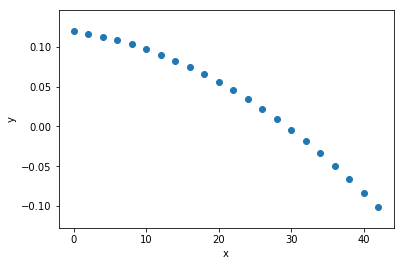

In [3]:
plt.scatter(df['x'],df['y'])
plt.xlabel('x')
plt.ylabel('y')

In [378]:
def calculate_euclidean_distance(x1, x2, y1, y2):
    return np.sqrt((x1 - x2) * (x1 - x2) + (y1 - y2) * (y1 - y2))

def calculate_sign(x1, x2, y1, y2):
    check_sum = (x2-x1) + (y2-y1)
    if check_sum < 0:
        return -1.0
    else:
        return 1.0    

def reference_spline(df):
    global spline
    return interp1d(df['x'], df['y'], kind='cubic',fill_value="extrapolate")

def calculate_boundaries(spline_start_x_value, spline_end_x_value):
    global start_x_
    global end_x_
    start_x_ = spline_start_x_value
    end_x_ = spline_end_x_value

In [392]:
def CalculateFrenetCoordinates(coordinate_x, coordinate_y, precision= 0.1):

    current_s = 0.0
    if (end_x_ - start_x_) > 0.0:
        current_x = start_x_
    else:
        current_x = end_x_
    while (current_x < (end_x_ - start_x_) > 0.0 if end_x_ else start_x_):
        distance = calculate_euclidean_distance(current_x, coordinate_x, spline(current_x), coordinate_y)
        frenet_coordinates = {'d':10000,'s':10000}
        if (distance <= frenet_coordinates['d']):
            closest_x = current_x
            frenet_coordinates['d'] = distance
            frenet_coordinates['s'] = current_s - precision

        current_s += calculate_euclidean_distance(
            current_x, (current_x - precision), spline(current_x), spline(current_x - precision))
        current_x += precision
    
    
    frenet_coordinates['d'] *= calculate_sign(current_x, coordinate_x, spline(current_x), coordinate_y)

    return frenet_coordinates





In [394]:
spline = reference_spline(df)
calculate_boundaries(spline_ob.x[0],spline_ob.x[spline_ob.x.size-1])
CalculateFrenetCoordinates(20,2)

{'d': -22.000480776343913, 's': 41.800680992585505}

In [358]:
# function to find the waypoint closest to a given point on the plane
def findWaypoint(x, y, df):
    closestDist =  1000000.0
    # iterate over the vector to find the shortest distance between the waypoints and the given point on the cartesian plane
    for i,row in df.iterrows():
        refTrajX = row['x']
        refTrajY = row['y']
        dist = calculate_euclidean_distance(x, y, refTrajX, refTrajY)
         #store the closest distance and the waypoint number
        if (dist < closestDist):
            closestDist = dist
            waypoint = i
        
    
    return waypoint


In [369]:
def cartesianToFrenet(x, y, df):
    frenet_latitude = 0.0;
    frenet_longitude= 0.0;
    frenet_long = 0
    frenet_vec = {}
    leftX = False;
    leftY = False;

    waypoint_num = findWaypoint(x, y, df);
    x2 = df['x'][waypoint_num+1]
    y2 = df['y'][waypoint_num+1]
    x1 = df['x'][len(df)-1]
    y1 = df['y'][len(df)-1]

    # compute x and y components of vector a between (x,y) and (x1,y1)
    ax = x - x1
    ay = y - y1
    # compute x and y components of vector b between (x2,y2) and (x1,y1)
    bx = x2 - x1
    by = y2 - y1
    # next step is to compute the projection of (x,y) on the reference trajectory
    # vector b lies on the reference trajectory and therefore kb.(a-kb) = 0
    # k = some scaling factor for vector b
    # k = a.b/b.b where . is the vector dot product
    scaling_fac = (ax*bx + ay*by)/(bx*bx + by*by)
    projection_x = scaling_fac*bx
    projection_y = scaling_fac*by

    # latitude on the frenet coordinate system
    frenet_lat = calculate_euclidean_distance(x, y, projection_x, projection_y)

#     # check if the given point (x,y) is on the left/right of the reference trajectory
    if(x > projection_x):
        leftX = True

    if(y > projection_y):
        leftY = True

    if(leftX and leftY):
        frenet_lat *= -1
    

#     #longitude on the frenet coordinate system
#     #compute distance until the waypoint closest to the given point (x,y) and add up the distance of this waypoint to the point (x,y)
    for i in range(waypoint_num+1):
        frenet_long += calculate_euclidean_distance(df['x'][i], df['y'][i], df['x'][i+1],df['y'][i+1])

    frenet_long += calculate_euclidean_distance(x, y,df['x'][waypoint_num] , df['y'][waypoint_num])

    return frenet_lat,frenet_long


In [368]:
cartesianToFrenet(20,2,df)

1.8871831560709835


(-28.52605421365465, 19.88758059084047)

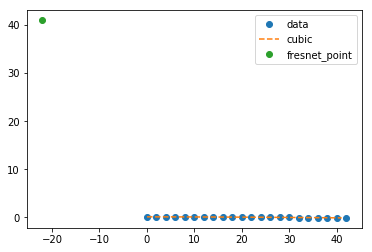

In [384]:
xnew = np.linspace(0, 41, num=41, endpoint=True)
import matplotlib.pyplot as plt
plt.plot(df['x'], df['y'], 'o', xnew, f2(xnew), '--',  -22.09941607999137, 41,'o')
plt.legend(['data', 'cubic','fresnet_point'], loc='best')
plt.show()

In [389]:
calculate_euclidean_distance(20, 2, df['x'][21],df['y'][21])

45.787055867431235